# Experimento 1
***
- Conjunto de Dados: VinBigData
- Testando a equalização de histograma em comparação com a mudança típica de escala

### Importação dos pacotes

In [1]:
import os
import pandas as pd
from sklearn.model_selection import train_test_split
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import layers
from tensorflow.keras import Model
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ModelCheckpoint

import warnings
warnings.filterwarnings("ignore")

### Pré-processamento nos dados

In [3]:
# lendo os dados de um arquivo csv
dataframe = pd.read_csv('/content/drive/MyDrive/vinbigdata/train.csv')
# criando uma coluna com os caminhos relativos as imagens
dataframe['image_path'] = '/content/drive/MyDrive/vinbigdata/train/' + dataframe.image_id + '.jpg'

In [4]:
print('total de imagens disponíveis:', str(len(set(dataframe['image_path']))))

total de imagens disponíveis: 15000


In [5]:
# visualizando os casos disponíveis
dataframe['class_name'].value_counts()

No finding            31818
Aortic enlargement     7162
Cardiomegaly           5427
Pleural thickening     4842
Pulmonary fibrosis     4655
Nodule/Mass            2580
Lung Opacity           2483
Pleural effusion       2476
Other lesion           2203
Infiltration           1247
ILD                    1000
Calcification           960
Consolidation           556
Atelectasis             279
Pneumothorax            226
Name: class_name, dtype: int64

In [6]:
# removendo os casos não relativos a distúrbios pulmonares
dataframe = dataframe[dataframe.class_name != 'Aortic enlargement']
dataframe = dataframe[dataframe.class_name != 'Cardiomegaly']
dataframe = dataframe[dataframe.class_name != 'Other lesion']
dataframe = dataframe[dataframe.class_name != 'Consolidation']

In [7]:
# separando os casos rotulados como normais e anormais
normal_cases = dataframe[(dataframe.class_id == 14) & (dataframe.class_name == 'No finding')]
abnormal_cases = dataframe[(dataframe.class_id != 14) & (dataframe.class_name != 'No finding')]

print('total de dados após a filtração:', str(len(set(normal_cases['image_path'])) + len(set(abnormal_cases['image_path']))))

total de dados após a filtração: 13948


In [8]:
# removendo as imagens repetidas
normal_path = list(set(normal_cases['image_path']))
abnormal_path = list(set(abnormal_cases['image_path']))

# criando dataframes especifos com caminhos para as imagens e rótulos
normal_data = pd.DataFrame(normal_path, columns = ['filepath'])
normal_data['target'] = 0
abnormal_data = pd.DataFrame(abnormal_path, columns = ['filepath'])
abnormal_data['target'] = 1

In [9]:
print('quantidade de dados rotulados como normais:', len(normal_data))
print('quantidade de dados rotulados como anormais:', len(abnormal_data))

quantidade de dados rotulados como normais: 10606
quantidade de dados rotulados como anormais: 3342


In [10]:
# removendo 69% dos casos normais para balancear os dados
normal, _ = train_test_split(normal_data, test_size = 0.69, random_state = 42)

In [11]:
print('quantidade de dados rotulados como normais:', len(normal))
print('quantidade de dados rotulados como anormais:', len(abnormal_data))

quantidade de dados rotulados como normais: 3287
quantidade de dados rotulados como anormais: 3342


In [12]:
# concatenando os dataframes de casos normais e anormais
full_data = pd.concat([normal, abnormal_data])

In [13]:
# misturando todos os dados do dataframe e reiniciando os valores dos índices 
full_data = full_data.sample(frac = 1, axis = 0, random_state = 42).reset_index(drop=True)

In [14]:
# modificando o formato dos dados para float32
dict_type = {'target': 'float32'}
full_data = full_data.astype(dict_type) 

In [15]:
# separando os dados de treinamento e de teste
train_df, test_df = train_test_split(full_data, stratify = full_data['target'],
                                     test_size = 0.2, random_state = 42)

In [16]:
# separando os dados de validação dos dados de treinamento
train_df, validation_df = train_test_split(train_df, stratify = train_df['target'],
                                           test_size = 0.2, random_state = 42)

In [17]:
# visualizando a quantidade de dados
print('quantidade de imagens de treinamento:', len(train_df['filepath']))
print('quantidade de rótulos de treinamento:', len(train_df['target']))
print('quantidade de imagens de teste:', len(test_df['filepath']))
print('quantidade de rótulos de teste:', len(test_df['target']))
print('quantidade de imagens de validação:', len(validation_df['filepath']))
print('quantidade de rótulos de validação:', len(validation_df['target']))

quantidade de imagens de treinamento: 4242
quantidade de rótulos de treinamento: 4242
quantidade de imagens de teste: 1326
quantidade de rótulos de teste: 1326
quantidade de imagens de validação: 1061
quantidade de rótulos de validação: 1061


### Aplicando mudança de escala típica

In [18]:
# normalizando as imagens de treinamento e aplicando aumento de dados
image_generator = ImageDataGenerator(rescale = 1./255.,
                                     rotation_range = 10, zoom_range = 0.2)

# criando o gerador de imagens de treinamento 
train_generator = image_generator.flow_from_dataframe(
                                                      dataframe = train_df,
                                                      directory = '',
                                                      x_col = 'filepath',
                                                      y_col = 'target',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'raw',
                                                      target_size = (256, 256))
# criando o gerador de imagens de validação 
valid_generator = image_generator.flow_from_dataframe(
                                                      dataframe = validation_df,
                                                      directory = '.', 
                                                      x_col = 'filepath',
                                                      y_col = 'target',
                                                      batch_size = 32,
                                                      seed = 42,
                                                      shuffle = True,
                                                      class_mode = 'raw',
                                                      target_size = (256, 256))

# normalizando as imagens de teste 
test_datagen = ImageDataGenerator(rescale = 1./255.)

test_generator = test_datagen.flow_from_dataframe(
                                                  dataframe = test_df, 
                                                  directory = '.',
                                                  x_col = 'filepath',
                                                  y_col = 'target',
                                                  batch_size = 32,
                                                  seed = 42,
                                                  shuffle = True,
                                                  class_mode = 'raw',
                                                  target_size = (256, 256))

Found 4242 validated image filenames.
Found 1061 validated image filenames.
Found 1326 validated image filenames.


### Preparando a rede neural convolucional

In [19]:
# baixando os pesos treinados da rede inception
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

--2021-03-03 17:03:17--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 172.253.122.128, 142.250.73.208, 142.250.31.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.253.122.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M   148MB/s    in 0.6s    

2021-03-03 17:03:17 (148 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]



In [20]:
# referenciando o local em que os pesos estão armazenados
local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# carregando a arquitetura inception pré-treinada
pre_trained_model = InceptionV3(input_shape = (256, 256, 3), 
                                include_top = False, 
                                weights = None)

# carregando os pesos treinados com outros dados 
pre_trained_model.load_weights(local_weights_file)

# definindo as flags iniciais  
pre_trained_model.trainable = True
set_trainable = False

# para a arquitetura inception, a rede será retreinada a partir da camada 'mixed6'
for layer in pre_trained_model.layers:
    if layer.name == 'mixed6':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

# visualizando a arquitetura definida
pre_trained_model.summary()

# obtendo a última camada como sendo a nomeada por 'mixed7'
last_layer = pre_trained_model.get_layer('mixed7')
last_output = last_layer.output

Model: "inception_v3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 127, 127, 32) 96          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 127, 127, 32) 0           batch_normalization[0][0]        
_______________________________________________________________________________________

In [21]:
# definindo uma camada de achatamento
x = layers.Flatten()(last_output)
# conecatando a rede uma camada com 1024 neurônios e função de ativação relu
x = layers.Dense(units = 1024, activation = 'relu')(x)     
# conecatando a rede uma camada com 128 neurônios e função de ativação relu
x = layers.Dense(units = 512, activation = 'relu')(x) 
# aplicando uma camada de dropout com uma taxa de 20% (normalização)
x = layers.Dropout(rate = 0.2)(x)                  
# adicionando uma camada de saída com um neurônio e uma função de ativação sigmoide
x = layers.Dense  (units = 1, activation = 'sigmoid')(x)           

# conecatando as camadas definidas acima com a arquitetura inception
model = Model(pre_trained_model.input, x) 

# compilando a rede 
model.compile(optimizer = optimizers.RMSprop(learning_rate = 0.0001), loss = 'binary_crossentropy', 
              metrics = ['acc'])

In [22]:
# definindo o caminho pelo qual os pesos serão armazenados 
filepath = "transferlearning_weights.hdf5"
# callback para salvar o melhor valor dos pesos em relação ao desempenho com os dados de validação 
checkpoint = ModelCheckpoint(filepath, monitor = 'val_acc', verbose = 1, save_best_only = True, mode = 'max')

In [23]:
# definindo um array de callbacks
callbacks = [checkpoint]

In [24]:
# treinando a rede neural convolucional
history = model.fit_generator(train_generator, steps_per_epoch = 4242 // 32, 
                              validation_data = valid_generator, validation_steps = 1061 // 32,
                              callbacks = callbacks, epochs = 10)

Epoch 1/10
132/132 [==============================] - 2172s 16s/step - loss: 0.7158 - acc: 0.7119 - val_loss: 0.2893 - val_acc: 0.8759

Epoch 00001: val_acc improved from -inf to 0.87595, saving model to transferlearning_weights.hdf5
Epoch 2/10
132/132 [==============================] - 1315s 10s/step - loss: 0.2867 - acc: 0.8795 - val_loss: 0.3376 - val_acc: 0.8845

Epoch 00002: val_acc improved from 0.87595 to 0.88447, saving model to transferlearning_weights.hdf5
Epoch 3/10
132/132 [==============================] - 1253s 10s/step - loss: 0.2461 - acc: 0.8944 - val_loss: 0.2309 - val_acc: 0.9081

Epoch 00003: val_acc improved from 0.88447 to 0.90814, saving model to transferlearning_weights.hdf5
Epoch 4/10
132/132 [==============================] - 1251s 10s/step - loss: 0.1941 - acc: 0.9136 - val_loss: 0.2520 - val_acc: 0.9044

Epoch 00004: val_acc did not improve from 0.90814
Epoch 5/10
132/132 [==============================] - 1248s 9s/step - loss: 0.1659 - acc: 0.9284 - val_los

In [25]:
model.evaluate(test_generator)

42/42 [==============================] - 534s 13s/step - loss: 0.4070 - acc: 0.9020


[0.4070454239845276, 0.9019607901573181]

In [26]:
best_model = model
best_model.load_weights('/content/transferlearning_weights.hdf5')

In [27]:
best_model.evaluate(test_generator)

42/42 [==============================] - 73s 2s/step - loss: 0.3351 - acc: 0.9148


[0.3351123332977295, 0.9147812724113464]

In [28]:
for i in range(0, 42):
  (x1, y1) = test_generator[i]
  if i == 0:
    x, y = x1, y1
  else:
    x = np.concatenate((x, x1))
    y = np.concatenate((y, y1))

In [29]:
predict = best_model.predict(x)

In [30]:
predict_ = []
for i in predict:
  if i > 0.40:
    predict_.append(1)
  else:
    predict_.append(0)

In [31]:
confusion_matrix(predict_, y)

array([[615,  66],
       [ 42, 603]])

In [32]:
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score

In [33]:
accuracy_score(predict_, y)

0.918552036199095

In [34]:
precision_recall_fscore_support(predict_, y)

(array([0.93607306, 0.90134529]),
 array([0.9030837 , 0.93488372]),
 array([0.91928251, 0.91780822]),
 array([681, 645]))

In [35]:
precision = 615 / (615 + 66)
precision

0.9030837004405287

In [36]:
recall = 615 / (615 + 42)
recall

0.9360730593607306

In [37]:
f1 = (2 * precision * recall) / (precision + recall)
f1

0.9192825112107623

In [38]:
model.save('model1')
best_model.save('model2')

INFO:tensorflow:Assets written to: model1/assets
INFO:tensorflow:Assets written to: model2/assets


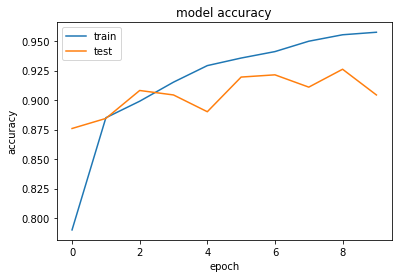

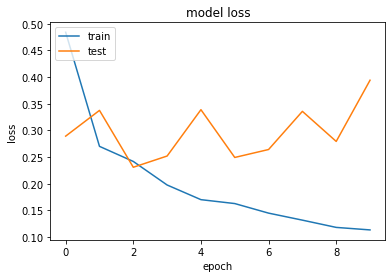

<Figure size 432x288 with 0 Axes>

In [40]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model-accuracy')
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
plt.savefig('model-loss')

In [41]:
!mv /content/experimento1-dataset4-parte1 /content/drive/MyDrive/experimentos